# CARICAMENTO DEL DATASET STANDFORD CARS

Scegliere se importare il dataset da **Kaggle** oppure caricarlo da **Drive** (se scaricato).

In [1]:
import kagglehub
import os

# Scarica il dataset
path = kagglehub.dataset_download("rickyyyyyyy/torchvision-stanford-cars")

print("Path to dataset files:", path)
dataset_path=path

100%|██████████| 1.83G/1.83G [00:27<00:00, 70.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rickyyyyyyy/torchvision-stanford-cars/versions/2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DeepLearning
dataset_path="/content/drive/MyDrive/DeepLearning/stanford_cars/dataset"

Mounted at /content/drive
/content/drive/MyDrive/DeepLearning


Importare le librerie necessarie e settare il seed.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import argparse
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import random
import matplotlib.pyplot as plt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id,seed):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)

set_seed(42)
# Generatore e worker seed
g = torch.Generator()
g.manual_seed(42)


Settare transforms per la **data augmentation**.

In [3]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.03),
            transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
            transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.3)),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

Caricamento del dataset Stanford Cars con una suddivisione 70:30

In [4]:
# load train ds
trainset = torchvision.datasets.StanfordCars(root=dataset_path, split='train',
                                              download=False, transform=data_transforms['train'])
class_names=trainset.classes

# load test set
full_test = torchvision.datasets.StanfordCars(root=dataset_path, split='test',
                                            download=False, transform=data_transforms['test'])

labels = np.array([label for _, label in full_test._samples])
labels_training = np.array([label for _, label in trainset._samples])

# test set in 60% test e 40% validation mantenendo le proporzioni delle classi
test_indices, val_indices = train_test_split(np.arange(len(labels)), test_size=0.4, stratify=labels, random_state=42)

testset = torch.utils.data.Subset(full_test, test_indices)
valset = torch.utils.data.Subset(full_test, val_indices)

print(f"Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}")


Train set size: 8144, Validation set size: 3217, Test set size: 4824


#**ANALISI DEL DATASET**

## Conteggio della presenza di ciascuna classe per valutare se il dataset è bilanciato e se ci sono classe che prevalgono o che scarseggiano.

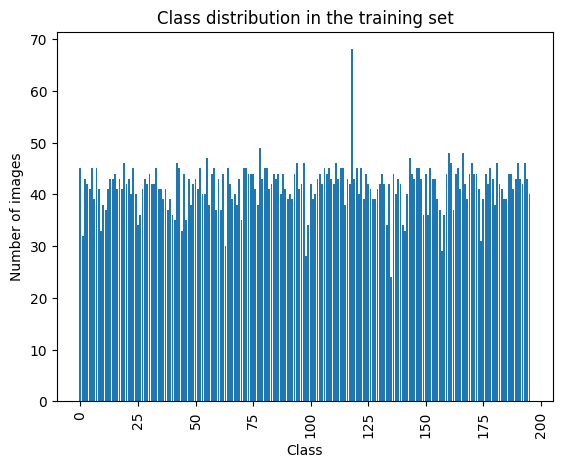


Classi più frequenti nel training set:
GMC Savana Van 2012: 68 images
Chrysler 300 SRT-8 2010: 49 images
Mitsubishi Lancer Sedan 2012: 48 images
Mercedes-Benz 300-Class Convertible 1993: 48 images
Jaguar XK XKR 2012: 47 images

Classi meno nel training set frequenti:
Rolls-Royce Phantom Drophead Coupe Convertible 2012: 31 images
Chevrolet Express Cargo Van 2007: 30 images
Maybach Landaulet Convertible 2012: 29 images
FIAT 500 Abarth 2012: 28 images
Hyundai Accent Sedan 2012: 24 images


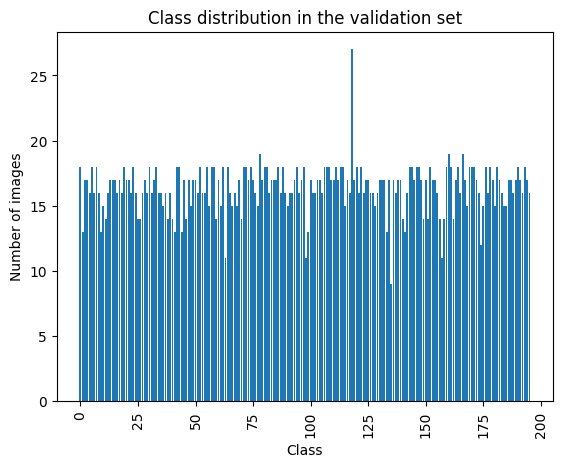


Classi più frequenti nel validation set:
GMC Savana Van 2012: 27 images
Chrysler 300 SRT-8 2010: 19 images
Mercedes-Benz 300-Class Convertible 1993: 19 images
Mitsubishi Lancer Sedan 2012: 19 images
Dodge Journey SUV 2012: 18 images

Classi meno nel training validation frequenti:
Rolls-Royce Phantom Drophead Coupe Convertible 2012: 12 images
Chevrolet Express Cargo Van 2007: 11 images
Maybach Landaulet Convertible 2012: 11 images
FIAT 500 Abarth 2012: 11 images
Hyundai Accent Sedan 2012: 9 images


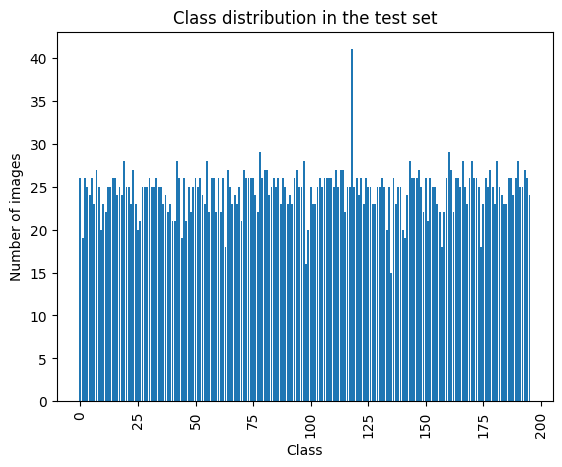


Classi più frequenti nel test set:
GMC Savana Van 2012: 41 images
Chrysler 300 SRT-8 2010: 29 images
Mercedes-Benz 300-Class Convertible 1993: 29 images
Mitsubishi Lancer Sedan 2012: 28 images
Suzuki Kizashi Sedan 2012: 28 images

Classi meno frequenti nel test set:
Rolls-Royce Phantom Drophead Coupe Convertible 2012: 18 images
Maybach Landaulet Convertible 2012: 18 images
Chevrolet Express Cargo Van 2007: 18 images
FIAT 500 Abarth 2012: 16 images
Hyundai Accent Sedan 2012: 15 images


In [5]:
labels_test = labels[test_indices]
labels_val = labels[val_indices]

######## TRAINING ##############

# Conta quante immagini per ogni classe
class_counts = Counter(labels_training)
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Class distribution in the training set")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

# Ordina per frequenza
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Visualizza le classi più frequenti e meno frequenti
num_top_classes = 5

most_common = sorted_classes[:num_top_classes]
least_common = sorted_classes[-num_top_classes:]

print("\nClassi più frequenti nel training set:")
for idx, count in most_common:
    print(f"{class_names[idx]}: {count} images")

print("\nClassi meno nel training set frequenti:")
for idx, count in least_common:
    print(f"{class_names[idx]}: {count} images")


######## VALIDATION ##############

# Conta quante immagini per ogni classe
class_counts = Counter(labels_val)
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Class distribution in the validation set")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

# Ordina per frequenza
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Visualizza le classi più frequenti e meno frequenti
num_top_classes = 5

most_common = sorted_classes[:num_top_classes]
least_common = sorted_classes[-num_top_classes:]

print("\nClassi più frequenti nel validation set:")
for idx, count in most_common:
    print(f"{class_names[idx]}: {count} images")

print("\nClassi meno nel training validation frequenti:")
for idx, count in least_common:
    print(f"{class_names[idx]}: {count} images")

######## TEST ##############

# Conta quante immagini per ogni classe
class_counts = Counter(labels_test)
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Class distribution in the test set")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

# Ordina per frequenza
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Visualizza le classi più frequenti e meno frequenti
num_top_classes = 5

most_common = sorted_classes[:num_top_classes]
least_common = sorted_classes[-num_top_classes:]

print("\nClassi più frequenti nel test set:")
for idx, count in most_common:
    print(f"{class_names[idx]}: {count} images")

print("\nClassi meno frequenti nel test set:")
for idx, count in least_common:
    print(f"{class_names[idx]}: {count} images")



## Visualizzazione di ogni classe presente nel dataset

### Confronto per ogni classe della versione originale e della versione augmented.

In [6]:
# Carica il dataset senza applicare augmentation
full_trainset_no_augmentation = torchvision.datasets.StanfordCars(root=dataset_path, split='train', download=False, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))


# Carica il dataset con le trasformazioni di augmentation
full_trainset_with_augmentation = torchvision.datasets.StanfordCars(root=dataset_path, split='train', download=False, transform=data_transforms['train'])


# Funzione per denormalizzare le immagini (usata per la visualizzazione)
def denorm(x):
    out = x * 0.229 + 0.485  # Denormalizza con i valori di mean e std di ImageNet
    return out.clamp(0, 1)


to_pil = transforms.ToPILImage()

In [7]:
# Dizionari per raccogliere un'immagine per classe
unique_classes_no_aug = {}
unique_classes_with_aug = {}

# Scorriamo il dataset originale per raccogliere un esempio per classe
for img, label in full_trainset_no_augmentation:
    if label not in unique_classes_no_aug:
        unique_classes_no_aug[label] = img
    if len(unique_classes_no_aug) == len(class_names):  # Fermiamo quando abbiamo tutte le classi
        break

# Scorriamo il dataset con augmentation per raccogliere un esempio per classe
for img, label in full_trainset_with_augmentation:
    if label not in unique_classes_with_aug:
        unique_classes_with_aug[label] = img
    if len(unique_classes_with_aug) == len(class_names):  # Fermiamo quando abbiamo tutte le classi
        break

# Ordiniamo per classe
sorted_classes = sorted(unique_classes_no_aug.items())

# Creiamo il plot con due colonne: originale a sinistra, aumentata a destra
fig, axes = plt.subplots(nrows=len(sorted_classes), ncols=2, figsize=(8, len(sorted_classes) * 2))

for i, (label, img_no_aug) in enumerate(sorted_classes):
    img_aug = unique_classes_with_aug[label]  # Corrispondente immagine aumentata

    # Immagine originale
    axes[i, 0].imshow(to_pil(denorm(img_no_aug)))
    axes[i, 0].set_title(f"Originale - {class_names[label]}", fontsize=7)
    axes[i, 0].axis("off")

    # Immagine aumentata
    axes[i, 1].imshow(to_pil(denorm(img_aug)))
    axes[i, 1].set_title(f"Augmented - {class_names[label]}", fontsize=7)
    axes[i, 1].axis("off")

plt.tight_layout()  # Ottimizza lo spazio
plt.show()

Output hidden; open in https://colab.research.google.com to view.

###Visualizzazione di una foto per ciascuna classe

In [8]:
# Ordiniamo per classe
sorted_classes = sorted(unique_classes_no_aug.items())

# Mostriamo le immagini con le etichette
fig, axes = plt.subplots(nrows=14, ncols=14, figsize=(30, 30))  # Grid 14x14 (196 classi)
axes = axes.flatten()  # Flatten per iterare facilmente

for i, (label, img_no_aug) in enumerate(sorted_classes):
    # Immagine originale
    axes[i].imshow(to_pil(denorm(img_no_aug)))
    axes[i].set_title(f"{class_names[label]}", fontsize=10)
    axes[i].axis("off")  # Rimuoviamo gli assi per pulizia

plt.tight_layout()  # Ottimizza la spaziatura
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [9]:
def show_images_of_class(dataset, target_class_idx, class_names, num_images=9):
    """
    Visualizza immagini di una certa classe da un dataset
    """
    found = 0
    plt.figure(figsize=(10, 10))
    for i in range(len(dataset)):
        img, label = dataset[i]
        if label == target_class_idx:
            img = denorm(img)
            img_show = img.permute(1, 2, 0).cpu().numpy()
            plt.subplot(3, 3, found + 1)
            plt.imshow(img_show)

            plt.title(class_names[label])
            plt.axis('off')
            found += 1
            if found >= num_images:
                break
    plt.tight_layout()
    plt.show()



# Mostra immagini di una classe
target_class_name = 'Chevrolet Express Van 2007'  # modificabile a piacere
target_class_idx = class_names.index(target_class_name)

show_images_of_class(full_trainset_no_augmentation, target_class_idx, class_names)

# Mostra immagini di una classe
target_class_name = 'Chevrolet Express Cargo Van 2007'  # modificabile a piacere
target_class_idx = class_names.index(target_class_name)

show_images_of_class(full_trainset_no_augmentation, target_class_idx, class_names)


Output hidden; open in https://colab.research.google.com to view.